# Unconditional Unet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inchan, outchan, 5, 1, 2),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outchan, outchan, 5, 1, 2),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class ConvBlockSmall(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inchan, outchan, 3, 1, 1),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outchan, outchan, 3, 1, 1),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class Down(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(Down, self).__init__()
        layers = [
            ConvBlock(inchan, outchan),
            nn.MaxPool2d(2),
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class Up(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(Up, self).__init__()
        layers = [
            nn.ConvTranspose2d(inchan, outchan, 2, 2),
            ConvBlock(outchan, outchan),
            ConvBlock(outchan, outchan),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
        x1 = torch.cat((x, res), 1)
        x2 = self.model(x1)
        return x2

class BottomDown(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(BottomDown, self).__init__()
        layers = [
            ConvBlockSmall(inchan, outchan),
            nn.MaxPool2d(2,2),
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class BottomUp(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(BottomUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(inchan, outchan, 3, 2),
            ConvBlockSmall(outchan, outchan),
            ConvBlockSmall(outchan, outchan),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.model(x)
        return x1

class EmbeddingNN(nn.Module):
    def __init__(self, indim, outdim):
        super(EmbeddingNN, self).__init__()

        self.indim = indim
        layers = [
            nn.Linear(indim, outdim),
            nn.ReLU(),
            nn.Linear(outdim, outdim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.indim)
        return self.model(x)


class UncondUnet(nn.Module):
    def __init__(self, inchan: int, outchan: int, n_feat: int = 128) -> None:
        super(UncondUnet, self).__init__()

        self.inchan = inchan
        self.n_feat = n_feat

        self.init_conv = ConvBlock(inchan, n_feat)

        self.down1 = Down(n_feat, n_feat)
        self.down2 = Down(n_feat, 2*n_feat)
        self.down3 = BottomDown(2*n_feat, 2*n_feat)

        self.timeembed = EmbeddingNN(1, 9*n_feat)

        self.up0 = BottomUp(3*n_feat,2*n_feat)
        self.up1 = Up(4*n_feat, n_feat)
        self.up2 = Up(2*n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2*n_feat, n_feat, 5, 1, 2),
            nn.BatchNorm2d(n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.inchan, 5, 1, 2),
        )

    def forward(self, x, t):

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2) #2*n_featby3by3

        timeembed = self.timeembed(t).view(-1,self.n_feat, 3, 3) #n_featby3by3
        bottom = torch.cat((down3, timeembed), 1) #3*n_featby3by3

        up1 = self.up0(bottom)
        up2 = self.up1(up1, down2)
        up3 = self.up2(up2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [ ]:
from typing import Dict, Tuple
import numpy as np
from torch.utils.data import Dataset, DataLoader

class DDPM(nn.Module):
    def __init__(self,noisemodel: nn.Module,betas: Tuple[float, float],totalSteps: int,criterion: nn.Module = nn.MSELoss(),) -> None:
        super(DDPM, self).__init__()
        self.noisemodel = noisemodel

        for k, v in ddpm_schedules(betas[0], betas[1], totalSteps).items():
            self.register_buffer(k, v)

        self.totalSteps = totalSteps
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        _ts = torch.randint(1, self.totalSteps + 1, (x.shape[0],)).to(x.device)
        eps = torch.randn_like(x)

        x_t = (self.sqrtab[_ts, None, None, None] * x + self.sqrtmab[_ts, None, None, None] * eps)

        return self.criterion(eps, self.noisemodel(x_t, _ts / self.totalSteps))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)
        x_i_process = []
        for i in range(self.totalSteps, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.noisemodel(x_i, torch.tensor(i / self.totalSteps).to(device).repeat(n_sample, 1))
            x_i = (self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i]) + self.sqrt_beta_t[i] * z)
            if i%20==0 or i==self.totalSteps:
              x_i_process.append(x_i.detach().cpu().numpy())

        return x_i, x_i_process


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:

    assert beta1 < beta2 < 1.0

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

# Forward Process example

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



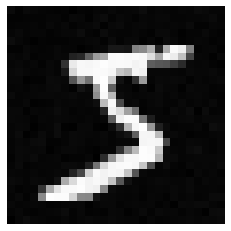

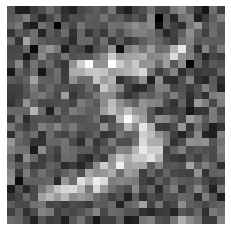

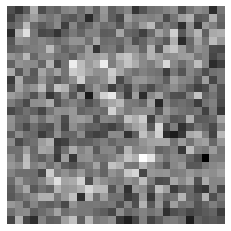

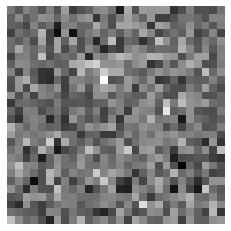

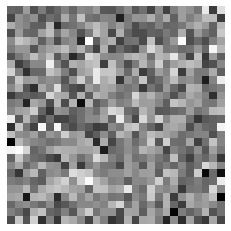

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

beta1 = 1e-4
beta2 = 0.02
totalSteps = 200
imgs = []
alpha_t, oneover_sqrta, sqrt_beta_t, alphabar_t, sqrtab, sqrtmab, mab_over_sqrtmab_inv = ddpm_schedules(beta1, beta2, totalSteps).items()

sqrtab = sqrtab[1]
sqrtmab = sqrtmab[1]

tf = transforms.Compose([transforms.ToTensor()])

dataset = MNIST("./data", train=True, download=True, transform=tf,)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

x,l = dataset[0]

for i in range(totalSteps):
  _ts = torch.randint(0, i+1, (x.shape[0],)).to(x.device)
  eps = torch.randn_like(x)
  x_t = (sqrtab[i, None, None, None] * x + sqrtmab[i, None, None, None] * eps)

  if i%40==0 or i==totalSteps:
    imgs.append(x_t)

for img in imgs:
  plt.figure()
  plt.imshow(img.squeeze(), cmap = "binary_r")
  plt.axis('off')


In [ ]:
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

gridsuncond = []

def train_mnist(
    n_epoch: int = 50, device: str = "cuda:0") -> None:

    ddpm = DDPM(noisemodel=UncondUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), totalSteps=200)
    ddpm.to(device)

    tf = transforms.Compose([transforms.ToTensor()])

    dataset = MNIST(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )

    dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)
    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        optim.param_groups[0]['lr'] = 1e-4*(1-i/n_epoch)

        pbar = tqdm(dataloader)

        for x, _ in pbar:
            ddpm.train()
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()

            pbar.set_description(f"loss: {loss:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            x_sample, _ = ddpm.sample(10, (1, 28, 28), device)
            grid = make_grid(x_sample.cpu(), normalize=False, value_range=(-1, 1), nrow=10)
            save_image(grid, f"./ddpmuncond/ddpm_sample{i}.png")
            gridsuncond.append(grid)

        torch.save(ddpm.state_dict(), f"./ddpmuncond.pth")

if __name__ == "__main__":
    train_mnist()

Epoch 0 : 


loss: 0.0707: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 1 : 


loss: 0.0668: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 2 : 


loss: 0.0596: 100%|██████████| 235/235 [00:24<00:00,  9.59it/s]


Epoch 3 : 


loss: 0.0559: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 4 : 


loss: 0.0457: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 5 : 


loss: 0.0486: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 6 : 


loss: 0.0527: 100%|██████████| 235/235 [00:24<00:00,  9.58it/s]


Epoch 7 : 


loss: 0.0448: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 8 : 


loss: 0.0502: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 9 : 


loss: 0.0454: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 10 : 


loss: 0.0389: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 11 : 


loss: 0.0402: 100%|██████████| 235/235 [00:24<00:00,  9.60it/s]


Epoch 12 : 


loss: 0.0377: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 13 : 


loss: 0.0427: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 14 : 


loss: 0.0401: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 15 : 


loss: 0.0364: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 16 : 


loss: 0.0339: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 17 : 


loss: 0.0326: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 18 : 


loss: 0.0341: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 19 : 


loss: 0.0404: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 20 : 


loss: 0.0357: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 21 : 


loss: 0.0367: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 22 : 


loss: 0.0344: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 23 : 


loss: 0.0321: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 24 : 


loss: 0.0376: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 25 : 


loss: 0.0320: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 26 : 


loss: 0.0347: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 27 : 


loss: 0.0351: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 28 : 


loss: 0.0328: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 29 : 


loss: 0.0314: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 30 : 


loss: 0.0330: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 31 : 


loss: 0.0329: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 32 : 


loss: 0.0425: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 33 : 


loss: 0.0308: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 34 : 


loss: 0.0320: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 35 : 


loss: 0.0347: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 36 : 


loss: 0.0328: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 37 : 


loss: 0.0344: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 38 : 


loss: 0.0285: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 39 : 


loss: 0.0321: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Epoch 40 : 


loss: 0.0319: 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]


Epoch 41 : 


loss: 0.0336: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 42 : 


loss: 0.0355: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 43 : 


loss: 0.0292: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 44 : 


loss: 0.0285: 100%|██████████| 235/235 [00:24<00:00,  9.60it/s]


Epoch 45 : 


loss: 0.0413: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Epoch 46 : 


loss: 0.0304: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 47 : 


loss: 0.0363: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Epoch 48 : 


loss: 0.0320: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch 49 : 


loss: 0.0311: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


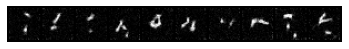

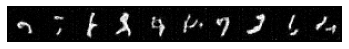

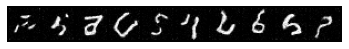

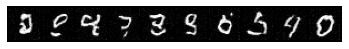

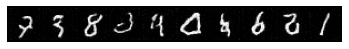

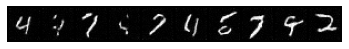

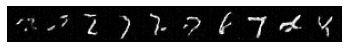

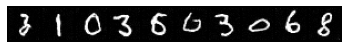

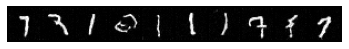

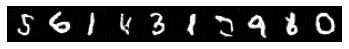

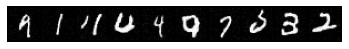

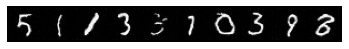

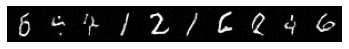

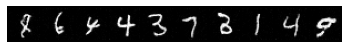

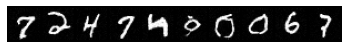

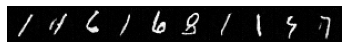

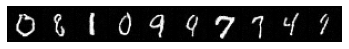

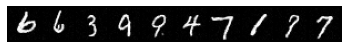

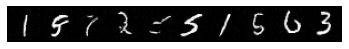

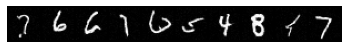

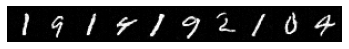

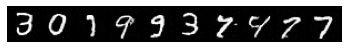

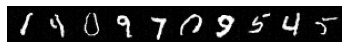

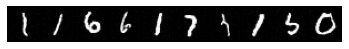

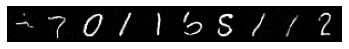

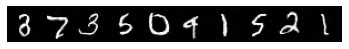

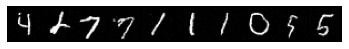

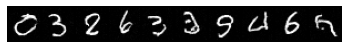

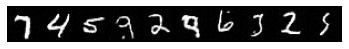

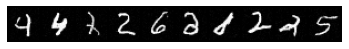

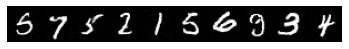

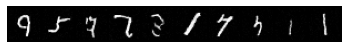

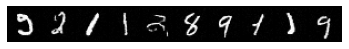

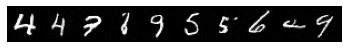

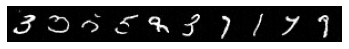

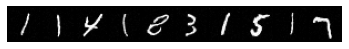

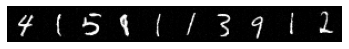

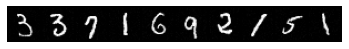

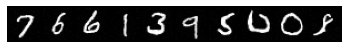

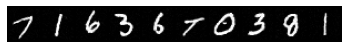

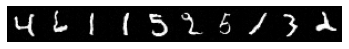

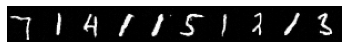

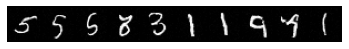

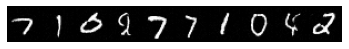

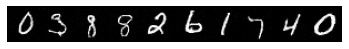

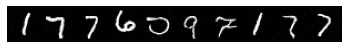

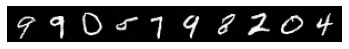

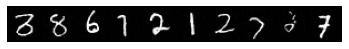

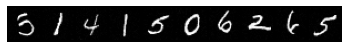

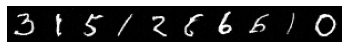

In [ ]:
for grid in gridsuncond:
  plt.figure()
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')

# Conditional Unet

In [ ]:
class CondUnet(nn.Module):
    def __init__(self, inchan: int, outchan: int, n_feat: int = 128) -> None:
        super(CondUnet, self).__init__()

        self.inchan = inchan
        self.n_feat = n_feat

        self.init_conv = ConvBlock(inchan, n_feat)

        self.down1 = Down(n_feat, n_feat)
        self.down2 = Down(n_feat, 2*n_feat)
        self.down3 = BottomDown(2*n_feat, 2*n_feat)

        self.timeembed = EmbeddingNN(1, 9*n_feat)
        self.contextembed = EmbeddingNN(10, 9*n_feat)

        self.up0 = BottomUp(4*n_feat, 2*n_feat)
        self.up1 = Up(4*n_feat, n_feat)
        self.up2 = Up(2*n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2*n_feat, n_feat, 5, 1, 2),
            nn.BatchNorm2d(n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.inchan, 5, 1, 2),
        )

    def forward(self, x, label, t):

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2) #2*n_featby3by3

        label = nn.functional.one_hot(label, num_classes=10).type(torch.float)
        
        contextembed = self.contextembed(label).view(-1, self.n_feat, 3, 3) #n_featby3by3
        timeembed = self.timeembed(t).view(-1, self.n_feat, 3, 3) #n_featby3by3
        bottom = torch.cat((down3, timeembed, contextembed), 1) #4*n_featby3by3

        up1 = self.up0(bottom)
        up2 = self.up1(up1, down2)
        up3 = self.up2(up2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [ ]:
class DDPMcond(nn.Module):
    def __init__(self,noisemodel: nn.Module,betas: Tuple[float, float],totalSteps: int,criterion: nn.Module = nn.MSELoss(),) -> None:
        super(DDPMcond, self).__init__()
        self.noisemodel = noisemodel

        for k, v in ddpm_schedules(betas[0], betas[1], totalSteps).items():
            self.register_buffer(k, v)

        self.totalSteps = totalSteps
        self.criterion = criterion

    def forward(self, x: torch.Tensor, label) -> torch.Tensor:

        _ts = torch.randint(1, self.totalSteps + 1, (x.shape[0],)).to(x.device)
        eps = torch.randn_like(x)

        x_t = (self.sqrtab[_ts, None, None, None] * x + self.sqrtmab[_ts, None, None, None] * eps)

        return self.criterion(eps, self.noisemodel(x_t, label, _ts / self.totalSteps))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)
        x_i_process = []
        label_i = torch.arange(0,10).to(device)

        for i in range(self.totalSteps, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.noisemodel(x_i, label_i, torch.tensor(i / self.totalSteps).to(device).repeat(n_sample, 1))
            x_i = (self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i]) + self.sqrt_beta_t[i] * z)
            if i%20==0 or i==self.totalSteps:
              x_i_process.append(x_i.detach().cpu().numpy())

        return x_i, x_i_process


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:

    assert beta1 < beta2 < 1.0

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}} 
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [ ]:
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

grids = []

def train_mnistcond(
    n_epoch: int = 50, device: str = "cuda:0") -> None:

    ddpmcond = DDPMcond(noisemodel=CondUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), totalSteps=200)
    ddpmcond.to(device)

    tf = transforms.Compose([transforms.ToTensor()])

    dataset = MNIST(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )

    dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)
    optim = torch.optim.Adam(ddpmcond.parameters(), lr=1e-4)

    for i in range(n_epoch):
        print(f"Epoch {i}: ")
        ddpmcond.train()

        optim.param_groups[0]['lr'] = 1e-4*(1-i/n_epoch)

        pbar = tqdm(dataloader)
        for x, label in pbar:
            ddpmcond.train()
            optim.zero_grad()
            x = x.to(device)
            label = label.to(device)
            loss = ddpmcond(x, label)
            loss.backward()
            pbar.set_description(f"loss: {loss:.4f}")
            optim.step()

        ddpmcond.eval()
        with torch.no_grad():
            xh, xp = ddpmcond.sample(10, (1, 28, 28), device)
            grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=10)
            save_image(grid, f"./ddpmcond/ddpmcond_sample{i}.png")
            grids.append(grid)

        torch.save(ddpmcond.state_dict(), f"./ddpmcond.pth")

if __name__ == "__main__":
    train_mnistcond()

Epoch 0: 


loss: 0.0934: 100%|██████████| 235/235 [00:24<00:00,  9.52it/s]


Epoch 1: 


loss: 0.0663: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 2: 


loss: 0.0512: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 3: 


loss: 0.0561: 100%|██████████| 235/235 [00:24<00:00,  9.54it/s]


Epoch 4: 


loss: 0.0525: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 5: 


loss: 0.0519: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 6: 


loss: 0.0703: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 7: 


loss: 0.0393: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 8: 


loss: 0.0484: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 9: 


loss: 0.0354: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 10: 


loss: 0.0332: 100%|██████████| 235/235 [00:24<00:00,  9.53it/s]


Epoch 11: 


loss: 0.0424: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 12: 


loss: 0.0367: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 13: 


loss: 0.0372: 100%|██████████| 235/235 [00:24<00:00,  9.53it/s]


Epoch 14: 


loss: 0.0580: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 15: 


loss: 0.0428: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 16: 


loss: 0.0385: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 17: 


loss: 0.0346: 100%|██████████| 235/235 [00:24<00:00,  9.54it/s]


Epoch 18: 


loss: 0.0404: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 19: 


loss: 0.0276: 100%|██████████| 235/235 [00:24<00:00,  9.53it/s]


Epoch 20: 


loss: 0.0320: 100%|██████████| 235/235 [00:24<00:00,  9.52it/s]


Epoch 21: 


loss: 0.0311: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 22: 


loss: 0.0362: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 23: 


loss: 0.0338: 100%|██████████| 235/235 [00:24<00:00,  9.58it/s]


Epoch 24: 


loss: 0.0378: 100%|██████████| 235/235 [00:24<00:00,  9.52it/s]


Epoch 25: 


loss: 0.0344: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 26: 


loss: 0.0273: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 27: 


loss: 0.0362: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 28: 


loss: 0.0308: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 29: 


loss: 0.0297: 100%|██████████| 235/235 [00:24<00:00,  9.58it/s]


Epoch 30: 


loss: 0.0305: 100%|██████████| 235/235 [00:24<00:00,  9.54it/s]


Epoch 31: 


loss: 0.0294: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 32: 


loss: 0.0288: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 33: 


loss: 0.0470: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 34: 


loss: 0.0275: 100%|██████████| 235/235 [00:24<00:00,  9.60it/s]


Epoch 35: 


loss: 0.0344: 100%|██████████| 235/235 [00:24<00:00,  9.53it/s]


Epoch 36: 


loss: 0.0323: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 37: 


loss: 0.0308: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 38: 


loss: 0.0310: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 39: 


loss: 0.0282: 100%|██████████| 235/235 [00:24<00:00,  9.53it/s]


Epoch 40: 


loss: 0.0293: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 41: 


loss: 0.0304: 100%|██████████| 235/235 [00:24<00:00,  9.56it/s]


Epoch 42: 


loss: 0.0282: 100%|██████████| 235/235 [00:24<00:00,  9.51it/s]


Epoch 43: 


loss: 0.0322: 100%|██████████| 235/235 [00:24<00:00,  9.54it/s]


Epoch 44: 


loss: 0.0306: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 45: 


loss: 0.0289: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 46: 


loss: 0.0312: 100%|██████████| 235/235 [00:24<00:00,  9.55it/s]


Epoch 47: 


loss: 0.0326: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 48: 


loss: 0.0290: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Epoch 49: 


loss: 0.0259: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


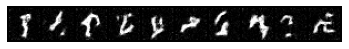

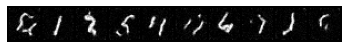

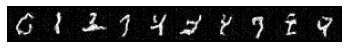

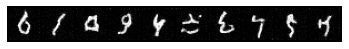

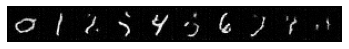

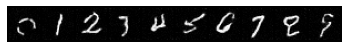

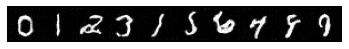

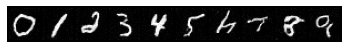

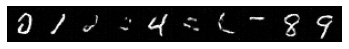

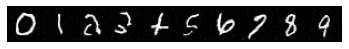

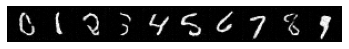

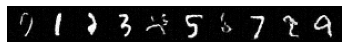

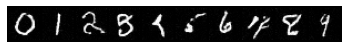

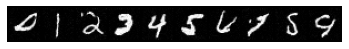

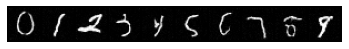

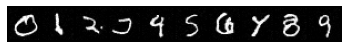

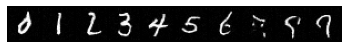

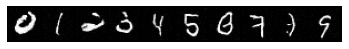

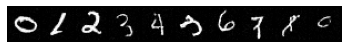

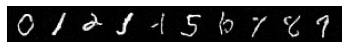

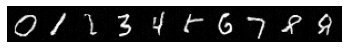

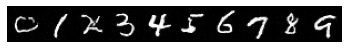

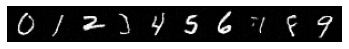

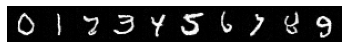

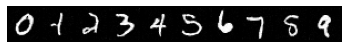

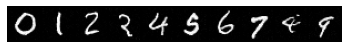

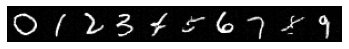

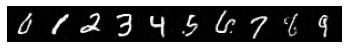

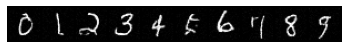

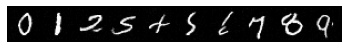

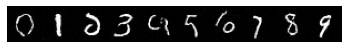

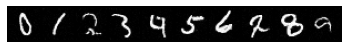

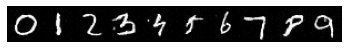

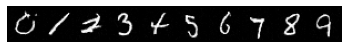

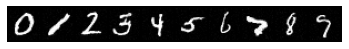

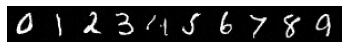

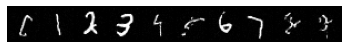

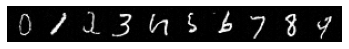

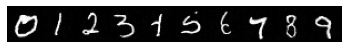

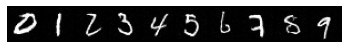

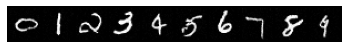

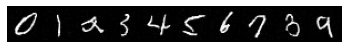

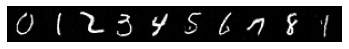

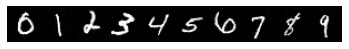

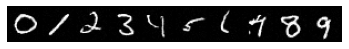

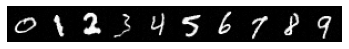

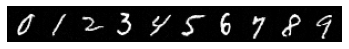

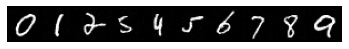

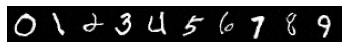

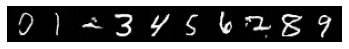

In [ ]:
for grid in grids:
  plt.figure()
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')

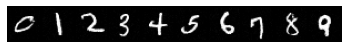

In [ ]:
device = "cuda:0"

ddpmcond = DDPMcond(noisemodel=CondUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), totalSteps=200)
ddpmcond.load_state_dict(torch.load("/content/ddpmcond.pth"))
ddpmcond.to(device)
 
ddpmcond.eval()
with torch.no_grad():
  xh, xp = ddpmcond.sample(10, (1, 28, 28), device)
  grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=10)
  plt.figure()
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')

torch.Size([10, 10, 1, 28, 28])


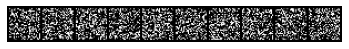

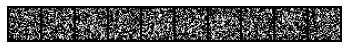

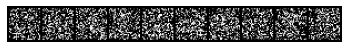

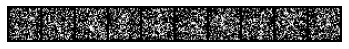

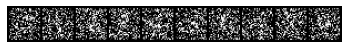

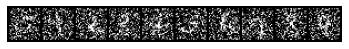

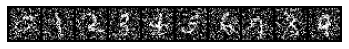

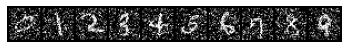

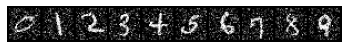

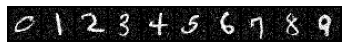

In [ ]:
xp = torch.Tensor(xp)
print(xp.shape)

for i in range(10):
  gridlearn = make_grid(xp[i], normalize=False, value_range=(-1,1), nrow=10)

  plt.figure()
  plt.imshow(gridlearn.permute(1,2,0))
  plt.axis('off')

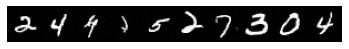

In [ ]:
ddpm = DDPM(noisemodel=UncondUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), totalSteps=200)
ddpm.load_state_dict(torch.load("/content/ddpmuncond.pth"))
ddpm.to(device)

ddpm.eval()
with torch.no_grad():
  xh, xp = ddpm.sample(10, (1, 28, 28), device)
  grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=10)
  plt.figure()
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')

torch.Size([10, 10, 1, 28, 28])


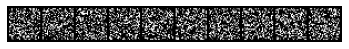

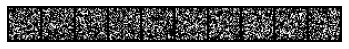

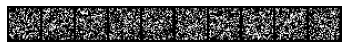

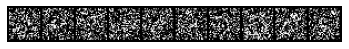

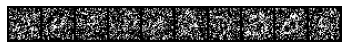

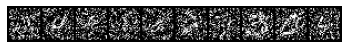

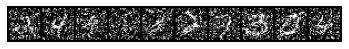

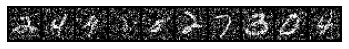

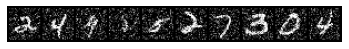

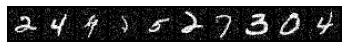

In [ ]:
xp = torch.Tensor(xp)
print(xp.shape)

for i in range(10):
  gridlearn = make_grid(xp[i], normalize=False, value_range=(-1,1), nrow=10)

  plt.figure()
  plt.imshow(gridlearn.permute(1,2,0))
  plt.axis('off')